# Semi Automatic Masking

For a folder with own images in ***fpath***, find the (top left, bottom right) corner locations for each image and add them in cell ***1. Add Positions***  
and save the csv file.

Use the custom dataloader ***Addmask*** for sampling from the dataframe.

For what is this used? Our LHQ dataloader randomly draws black rectangles and applies them to the dataset images. However, as users, we would like to choose the exact mask to be inpainted for a desired image. This notebook presents a way to select the rectangular mask by giving two points.

Another possible solution would be to add the mask with some editing tool. But when compression algorithms are involved, the border pixels between the image and mask become blurry and do not remain pure black. This causes the model not to inpaint them since it has been trained to inpaint pixels in the rectangle with the color value 0.

We used this function to crop out the RWTH Clinic or a llama by inpainting landscape images as a demo in our final presentation.

In [106]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import Dataset
import os
import pandas as pd
import numpy as np
from PIL import Image

## 1. Settings

In [107]:
######
ext = ".png"
fpath = "./test/"
new_folder = "./created"
csv_path = "./mask_df.csv"
######
assert os.path.exists(fpath)

In [133]:
file_list = []
for root, dirs, files in os.walk(fpath, topdown=False):
    for name in sorted(files):
        file_list.append(os.path.join(root, name))

pos = [None for file in file_list]
df = pd.DataFrame({"Filepath":file_list,"x1":pos,"y1":pos,"x2":pos,"y2":pos})
df = df[df["Filepath"].str.endswith(ext)]
df

Filepath    x1    y1    x2    y2
0   ./test/raw_0_0.png  None  None  None  None
1  ./test/raw_0_10.png  None  None  None  None
2   ./test/raw_0_5.png  None  None  None  None
3   ./test/raw_0_9.png  None  None  None  None

## 1. Add positions
### run this cell for each image to change


Top left corner = (x1,y1)


Bottom right corner = (x2,y2)

In [143]:
######
idx = 3 # image
x1,y1 = 61,95
x2,y2 = 128,128
######

df.iloc[idx][1:] = pd.Series({"x1":x1,
                            "y1":y1,
                            "x2":x2,
                            "y2":y2})

"""
Additional feature: use to copy rows to create multiple maskings for same image
idx_c = 0
additional_row = df.iloc[idx_c].to_frame().T
df = pd.concat([df,additional_row], ignore_index=True)
df
"""

'\nuse to copy rows to create multiple maskings for same image\nidx_c = 0\nadditional_row = df.iloc[idx_c].to_frame().T\ndf = pd.concat([df,additional_row], ignore_index=True)\ndf\n'

## Safe CSV!

In [110]:
df = df.dropna()
df.to_csv(csv_path)

## Test for a single image

61 95 128 128


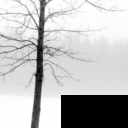

In [117]:
new_df = pd.read_csv(csv_path,index_col=False)
new_df = new_df.dropna()

######
idx= 0
######

path =  new_df.iloc[idx].Filepath
x1,y1,x2,y2 = new_df.iloc[idx][2:]
img = Image.open(path)
print(x1,y1,x2,y2)

totensor = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])
topil = transforms.Compose([transforms.Normalize(mean=(-1,-1,-1),std=(2,2,2)),transforms.ToPILImage()])
img_tensor = totensor(img)
img_tensor.size()

img_tensor[:,y1:y2,x1:x2] = -1

topil(img_tensor)

# Dataloader
which accepts the newly created df

In [120]:
class Addmask(Dataset):
    def __init__(self,df):
      self.df = df.dropna()
      self.totensor = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])
    def __len__(self):
      return len(self.df)

    def __getitem__(self,idx):
      path =  self.df.iloc[idx].Filepath
      x1,y1,x2,y2 = self.df.iloc[idx][2:]
      img = Image.open(path)
      img_tensor = self.totensor(img)
      img_tensor[:,y1:y2,x1:x2] = -1
      return img_tensor


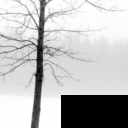

In [121]:
dataset = Addmask(new_df)
topil(dataset.__getitem__(0))

## OR Safe as png

In [123]:
for idx in range(dataset.__len__()):
  img = topil(dataset.__getitem__(0))
  path = os.path.join(new_folder,f"img{idx}.png")
  img.save(path,"PNG")